# Master in Applied Artificial Intelligence

## Course: *Fintech and Digital Innovation in Finance*

### **Course Project – Part 2**
### Semantic search and Vector Database on S&P 500 news

---

**Institution:** Tecnológico de Monterrey

**Instructors:** Marie-Ève Malette, Yetnalezi Quintas Ruiz

**Author:** Alejandro Díaz Villagómez | A01276769

**Date:** August 4th, 2025

---

# Introduction to vector databases on S&P 500 news

 # 📌 Objectives
 
 By the end of this notebook, students will be able to:
 
 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.
 
 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.
 
 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.
 
 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.
 
 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.
 
 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.
 
 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
# !pip install -q pandas faiss-cpu sentence-transformers scikit-learn
# !pip freeze > ../requirements.txt

In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [3]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news[['TITLE', 'SUMMARY', 'TICKER', 'PROVIDER', 'PUBLICATION_DATE']].head())

,TITLE,SUMMARY,TICKER,PROVIDER,PUBLICATION_DATE
0,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,MMM,StockStory,2025-05-29
1,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,MMM,StockStory,2025-05-27
2,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",MMM,Zacks,2025-05-22
3,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,MMM,StockStory,2025-05-22
4,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,MMM,StockStory,2025-05-19


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:
 
### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.
 
### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):
 
 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).
 
 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.
 
You will test your class at the end.

In [4]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Combine the TITLE and SUMMARY columns into a single column for embedding
df_news['EMBEDDED_TEXT'] = df_news['TITLE'].fillna('') + '. ' + df_news['SUMMARY'].fillna('')
display(df_news[['TITLE', 'SUMMARY', 'EMBEDDED_TEXT']].head())

,TITLE,SUMMARY,EMBEDDED_TEXT
0,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2 Dow Jones Stocks with Promising Prospects an...
1,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,3 S&P 500 Stocks Skating on Thin Ice. The S&P ...
2,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",3M Rises 15.8% YTD: Should You Buy the Stock N...
3,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...
4,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,3 Cash-Producing Stocks with Questionable Fund...


In [5]:
# Step 2: Load the pre-trained model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Step 3: Define CustomVectorStore class
class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        """
        Accepts an embedding model, list of documents, and corresponding metadata. 
        Computes and stores embeddings for all documents.
        """
        assert len(documents) == len(metadata), "Documents and metadata must be the same length."

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.embedding_model.encode(documents, convert_to_numpy=True)

    def search(self, query, k=5, metadata_filter=None):
        """
        Takes a query and returns the top k most similar documents, optionally filtered using metadata.
        """
        # If a metadata_filter function is provided, apply it before computing similarity.
        if metadata_filter:
            filtered = [(doc, meta, emb) for doc, meta, emb in zip(self.documents, self.metadata, self.embeddings)
                        if metadata_filter(meta)]
            if not filtered:
                return []

            docs_filtered, meta_filtered, emb_filtered = zip(*filtered)
        else:
            docs_filtered, meta_filtered, emb_filtered = self.documents, self.metadata, self.embeddings

        # Compute the embedding for the query
        query_embedding = self.embedding_model.encode([query], convert_to_numpy=True)

        # Use cosine similarity to compute distances.
        similarities = cosine_similarity(query_embedding, np.array(emb_filtered))[0]

        # Return the top k results as tuples of: (document, metadata, similarity score)
        top_k_indices = np.argsort(similarities)[::-1][:k]
        results = [(docs_filtered[i], meta_filtered[i], similarities[i]) for i in top_k_indices]
        return results


## Create and populate the vector store
 
 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.
 
 After initializing the store, you should be able to perform searches using: 
'store.search("Apple earnings", k=3)'


In [7]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Convert the combined EMBEDDED_TEXT column into a list of strings.
documents = df_news['EMBEDDED_TEXT'].tolist()
print(f"Number of documents: {len(documents)}")
print("Sample documents:")
print("-" * 50)
for i, doc in enumerate(documents[:5]):
    print(f"Document {i+1}: {doc[:100]}...")  # Print first 100 characters of each document

Number of documents: 4871
Sample documents:
--------------------------------------------------
Document 1: 2 Dow Jones Stocks with Promising Prospects and 1 to Avoid. The Dow Jones (^DJI) is made up of 30 of...
Document 2: 3 S&P 500 Stocks Skating on Thin Ice. The S&P 500 (^GSPC) is often seen as a benchmark for strong bu...
Document 3: 3M Rises 15.8% YTD: Should You Buy the Stock Now or Wait?. MMM is making strides in the aerospace, i...
Document 4: Q1 Earnings Roundup: 3M (NYSE:MMM) And The Rest Of The General Industrial Machinery Segment. Quarter...
Document 5: 3 Cash-Producing Stocks with Questionable Fundamentals. While strong cash flow is a key indicator of...


In [8]:
# Setp 2: Create a metadata list of dictionaries for each document with keys: 'PUBLICATION_DATE', 'TICKER', 'PROVIDER'
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')
print(f"Number of metadata entries: {len(metadata)}")
print("Sample metadata:")
print("-" * 50)
for i, meta in enumerate(metadata[:5]):
    print(f"Metadata {i+1}: {meta}")

Number of metadata entries: 4871
Sample metadata:
--------------------------------------------------
Metadata 1: {'PUBLICATION_DATE': datetime.date(2025, 5, 29), 'TICKER': 'MMM', 'PROVIDER': 'StockStory'}
Metadata 2: {'PUBLICATION_DATE': datetime.date(2025, 5, 27), 'TICKER': 'MMM', 'PROVIDER': 'StockStory'}
Metadata 3: {'PUBLICATION_DATE': datetime.date(2025, 5, 22), 'TICKER': 'MMM', 'PROVIDER': 'Zacks'}
Metadata 4: {'PUBLICATION_DATE': datetime.date(2025, 5, 22), 'TICKER': 'MMM', 'PROVIDER': 'StockStory'}
Metadata 5: {'PUBLICATION_DATE': datetime.date(2025, 5, 19), 'TICKER': 'MMM', 'PROVIDER': 'StockStory'}


In [9]:
# Step 3: Create an instance of CustomVectorStore
vector_store = CustomVectorStore(
    embedding_model=embedding_model, 
    documents=documents, 
    metadata=metadata
)

In [10]:
# Step 4: Test the search functionality
test_results = vector_store.search("Apple earnings", k=3)

for doc, meta, score in test_results:
    print(f"Similarity: {score:.4f}")
    print(f"Date: {meta['PUBLICATION_DATE']} | Ticker: {meta['TICKER']} | Provider: {meta['PROVIDER']}")
    print(f"Text: {doc[:300]}...")
    print("-" * 50)

Similarity: 0.5784
Date: 2025-05-28 | Ticker: HUM | Provider: Simply Wall St.
Text: Humana (NYSE:HUM) Sees Revenue Increase in First-Quarter Earnings to US$32,112 Million. Humana (NYSE:HUM) recently reported first-quarter earnings, showcasing a revenue increase from USD 29,611 million to USD 32,112 million and a net income rise from USD 741 million to USD 1,244 million. Despite thi...
--------------------------------------------------
Similarity: 0.5687
Date: 2025-04-30 | Ticker: OKE | Provider: Simply Wall St.
Text: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion. ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its qu...
--------------------------------------------------
Similarity: 0.5654
Date: 2025-05-01 | Ticker: APTV | Provider: Barrons.com
Text: Aptiv Stock Rises. Earnings Were Great, B

## Using your vector store and analyzing the results

### Retrieve AI Announcements
 
 Now that your vector store is working, let's use it to retrieve relevant documents.
 
 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text
 

In [11]:
# CODE HERE
# Use as many coding cells as you need

# Realizar búsqueda semántica
results = vector_store.search("AI announcement", k=50)

for idx, (doc, meta, score) in enumerate(results, 1):
    print(f"Result #{idx}")
    print(f"\tSimilarity Score   : {score:.4f}")
    print(f"\tTICKER             : {meta['TICKER']}")
    print(f"\tPUBLICATION_DATE   : {meta['PUBLICATION_DATE']}")
    print(f"\tPROVIDER           : {meta['PROVIDER']}")
    print(f"\tDocument Text      : {doc}")
    print("-" * 50)

Result #1
	Similarity Score   : 0.5574
	TICKER             : JKHY
	PUBLICATION_DATE   : 2025-03-17
	PROVIDER           : Insider Monkey
	Document Text      : Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
--------------------------------------------------
Result #2
	Similarity Score   : 0.5518
	TICKER             : ADBE
	PUBLICATION_DATE   : 2025-05-27
	PROVIDER           : Investor's Business Daily
	Document Text      : AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
-----------

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?
 
 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [12]:
# CODE HERE
# Use as many coding cells as you need

# Obtain tickers from the results
tickers = [meta['TICKER'] for _, meta, _ in results]

# Count the frequency of each ticker
ticker_counts = Counter(tickers)

print("Top TICKERs in 'AI announcement' search results:")
print("-" * 50)
for ticker, count in ticker_counts.most_common():
    print(f"{ticker}: {count} times")


Top TICKERs in 'AI announcement' search results:
--------------------------------------------------
PLTR: 5 times
BKR: 3 times
AMD: 3 times
QCOM: 2 times
GOOG: 2 times
AMZN: 2 times
EXPE: 2 times
MSFT: 2 times
CTSH: 2 times
INTC: 2 times
JKHY: 1 times
ADBE: 1 times
WSM: 1 times
CEG: 1 times
RSG: 1 times
NVDA: 1 times
INTU: 1 times
GOOGL: 1 times
NFLX: 1 times
YUM: 1 times
SMCI: 1 times
ORCL: 1 times
META: 1 times
ABNB: 1 times
PYPL: 1 times
CSCO: 1 times
NOW: 1 times
ROK: 1 times
HPQ: 1 times
DELL: 1 times
CRM: 1 times
IT: 1 times
FFIV: 1 times
AVGO: 1 times
KMX: 1 times


**RESPONSE:**

The results from the top 50 most semantically relevant articles to the query "AI announcement" reveal that certain companies appear more frequently than others. Notably, Palantir Technologies (PLTR) leads with 5 occurrences, followed by companies such as Baker Hughes (BKR), Advanced Micro Devices (AMD), and Qualcomm (QCOM).

Other well-known technology leaders, including Amazon (AMZN), Google (GOOG, GOOGL), Microsoft (MSFT), Intel (INTC), Meta (META), and NVIDIA (NVDA), also appear in the results, albeit with fewer occurrences.

This distribution highlights a mix of established AI leaders and less traditionally prominent players in the AI space. While the presence of companies like Microsoft, Google, and NVIDIA is expected given their well-known AI investments, the prominence of Palantir (PLTR) suggests a significant media footprint or strategic positioning in AI-related narratives, which may exceed its perceived market dominance.

Furthermore, the presence of firms like Expedia (EXPE), CarMax (KMX), and Williams-Sonoma (WSM) indicates that AI announcements are not confined to core tech companies. This reflects the cross-sector adoption of AI technologies, suggesting that semantic search captures a broader and more nuanced picture of AI discourse in financial news.

Overall, the results align with the growing ubiquity of AI across industries, but also raise interesting questions about media attention vs. actual technological leadership.

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?
 
 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

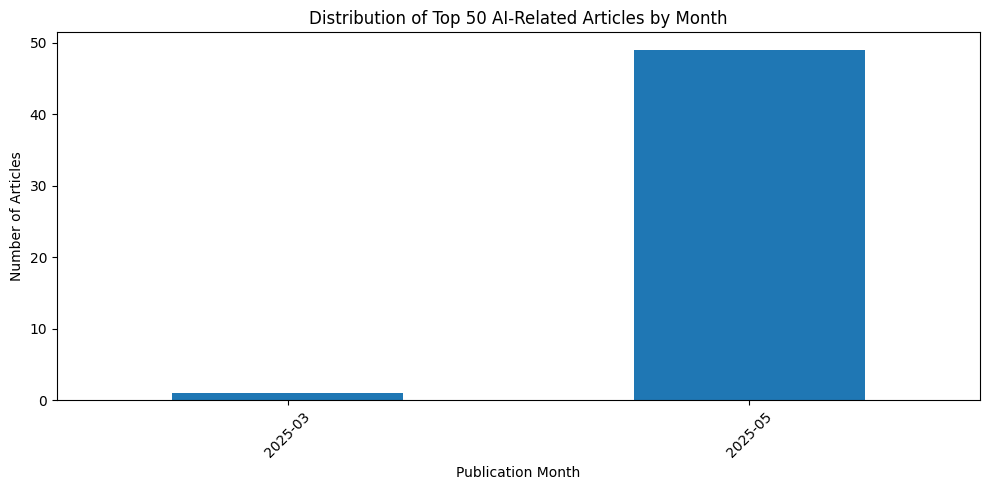

In [13]:
# CODE HERE
# Use as many coding cells as you need

# Obtain publication dates from the results
dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]

# Convert dates to datetime objects for easier handling
date_series = pd.to_datetime(pd.Series(dates))

# Plot the distribution of publication dates by month
plt.figure(figsize=(10, 5))
date_series.dt.to_period("M").value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Top 50 AI-Related Articles by Month")
plt.xlabel("Publication Month")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**RESPONSE:**

The histogram clearly shows that AI-related news articles are heavily clustered in recent months, rather than being evenly distributed over time. Specifically, May 2025 accounts for the overwhelming majority of the top 50 most semantically relevant documents retrieved using the query "AI announcement".

This concentration suggests that AI has recently emerged as a dominant theme in financial news and corporate communication. The absence of a more uniform distribution indicates that AI-related narratives are not consistently present across months but instead tend to surge in waves, likely triggered by external factors.

Several plausible explanations may account for the observed spike in AI announcements:

* **Earnings Season and Strategic Positioning**: May often coincides with Q1 earnings calls, where companies highlight strategic initiatives. Given the current momentum in AI, many firms may have chosen this window to emphasize AI-related investments to attract investor attention.

* **Technological Milestones**: Recent breakthroughs or product releases (such as new generative AI capabilities) may have prompted a surge of press releases and news coverage as firms seek to align themselves with industry trends.

* **Market Sentiment and Competitive Signaling**: Companies may also be reacting to peer behavior or market expectations. In a competitive landscape, highlighting AI initiatives can be seen as a signal of innovation and forward-thinking, especially in tech-adjacent sectors.

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.
 
 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.
 
 FAISS supports multiple similarity types. For cosine similarity, we must:
 
 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity
 

In [14]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Encode the text into embeddings
faiss_embeddings = embedding_model.encode(documents, convert_to_numpy=True)
print(f"Number of embeddings: {faiss_embeddings.shape[0]}")
print(f"Embedding shape: {faiss_embeddings.shape[1]}")
print("Sample embeddings:")
print("-" * 50)
print(faiss_embeddings[:5])

Number of embeddings: 4871
Embedding shape: 384
Sample embeddings:
--------------------------------------------------
[[-0.02074652 -0.07974351 -0.01314059 ... -0.06502932  0.04035698
   0.09408527]
 [-0.02989379 -0.07960927 -0.02947612 ... -0.13813816  0.00165378
   0.06716193]
 [-0.04363823 -0.09674904  0.00970045 ... -0.18255512 -0.05192295
   0.03005725]
 [-0.02705002 -0.04660505 -0.00699291 ... -0.15708081  0.01490478
   0.00854438]
 [-0.03567581 -0.11739411 -0.04980998 ... -0.05203956  0.11068767
   0.06846985]]


In [15]:
# Step 2: Normalize the embeddings to unit length (L2 normalization)
faiss.normalize_L2(faiss_embeddings)

# Check norms to ensure they are all 1.0
norms = np.linalg.norm(faiss_embeddings, axis=1)
print(f"Norm check — min: {norms.min():.5f}, max: {norms.max():.5f}")
assert np.allclose(norms, 1.0), "❌ Not all vectors are properly normalized."

print("Sample normalized embeddings:")
print("-" * 50)
print(faiss_embeddings[:5])

Norm check — min: 1.00000, max: 1.00000
Sample normalized embeddings:
--------------------------------------------------
[[-0.02074653 -0.07974352 -0.01314059 ... -0.06502933  0.04035698
   0.09408528]
 [-0.02989379 -0.07960927 -0.02947612 ... -0.13813816  0.00165378
   0.06716193]
 [-0.04363823 -0.09674904  0.00970045 ... -0.18255512 -0.05192295
   0.03005725]
 [-0.02705002 -0.04660505 -0.00699291 ... -0.15708081  0.01490478
   0.00854438]
 [-0.03567581 -0.11739411 -0.04980998 ... -0.05203956  0.11068767
   0.06846985]]


We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [16]:
# CODE HERE
# Use as many coding cells as you need

# Step 3: Create a FAISS index
dimension = faiss_embeddings.shape[1]  # 384 for all-MiniLM-L6-v2
index = faiss.IndexFlatIP(dimension)
print(f"FAISS index created with dimension: {dimension}")

FAISS index created with dimension: 384


In [17]:
# Step 4: Add the normalized embeddings to the index
index.add(faiss_embeddings)
print(f"Number of vectors in the index: {index.ntotal}")

Number of vectors in the index: 4871


### Create a `FaissVectorStore` class with a `.search()` method.
 
 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata 

In [18]:
# CODE HERE
# Use as many coding cells as you need

class FaissVectorStore:
    def __init__(self, index, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must match in length."

        self.index = index
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = faiss_embeddings  # precomputed, normalized

    def search(self, query, k=5, metadata_filter=None):
        # Encode and normalize the query vector
        query_vector = self.embedding_model.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(query_vector)

        # Optional metadata filtering
        if metadata_filter:
            filtered_items = [(i, doc, meta) for i, (doc, meta) in enumerate(zip(self.documents, self.metadata))
                              if metadata_filter(meta)]
            if not filtered_items:
                return []

            indices, docs_filtered, meta_filtered = zip(*filtered_items)
            filtered_vectors = self.embeddings[list(indices)]

            # FAISS search does not support filtering directly, so we compute cosine_similarity scores manually
            scores = np.dot(filtered_vectors, query_vector.T).squeeze()
            top_k_idx = np.argsort(scores)[::-1][:k]

            return [(docs_filtered[i], meta_filtered[i], scores[i]) for i in top_k_idx]

        else:
            # Direct FAISS search
            scores, idxs = self.index.search(query_vector, k)
            results = [(self.documents[i], self.metadata[i], scores[0][rank]) for rank, i in enumerate(idxs[0])]
            return results

 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`
 
 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text 

In [19]:
# CODE HERE
# Use as many coding cells as you need

# Instantiate the FaissVectorStore
faiss_vector_store = FaissVectorStore(
    index=index,
    embedding_model=embedding_model,
    documents=documents,
    metadata=metadata
)

In [20]:
faiss_results = faiss_vector_store.search("AI announcement", k=50)

for idx, (doc, meta, score) in enumerate(faiss_results, 1):
    print(f"Result #{idx}")
    print(f"\tSimilarity Score   : {score:.4f}")
    print(f"\tTICKER             : {meta['TICKER']}")
    print(f"\tPUBLICATION_DATE   : {meta['PUBLICATION_DATE']}")
    print(f"\tPROVIDER           : {meta['PROVIDER']}")
    print(f"\tDocument Text      : {doc}")
    print("-" * 50)

Result #1
	Similarity Score   : 0.5574
	TICKER             : JKHY
	PUBLICATION_DATE   : 2025-03-17
	PROVIDER           : Insider Monkey
	Document Text      : Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]
--------------------------------------------------
Result #2
	Similarity Score   : 0.5518
	TICKER             : ADBE
	PUBLICATION_DATE   : 2025-05-27
	PROVIDER           : Investor's Business Daily
	Document Text      : AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.
-----------

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:
 
 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [21]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation', 
    'Cryptocurrency'
]

In [22]:
# CODE HERE
# Use as many coding cells as you need

for query in test_queries:
    print(f"\nQuery: '{query}'\n")

    print("a) CustomVectorStore Results:")
    custom_results = vector_store.search(query, k=5)
    for i, (doc, meta, score) in enumerate(custom_results, 1):
        print(f"\t{i}. [{meta['TICKER']}] {doc[:100]}... (Score: {score:.4f})")

    print("\nb) FaissVectorStore Results:")
    faiss_results = faiss_vector_store.search(query, k=5)
    for i, (doc, meta, score) in enumerate(faiss_results, 1):
        print(f"\t{i}. [{meta['TICKER']}] {doc[:100]}... (Score: {score:.4f})")

    print("-" * 50)


Query: 'Stock price drop'

a) CustomVectorStore Results:
	1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses ar... (Score: 0.5427)
	2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachea... (Score: 0.5408)
	3. [CRL] Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, W... (Score: 0.5395)
	4. [KR] Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note. Kroger (KR) closed at $67.83 ... (Score: 0.5386)
	5. [PTC] 2 Stocks Down 46% and 14% to Buy Right Now. AMD probably won't beat Nvidia in the AI processor marke... (Score: 0.5371)

b) FaissVectorStore Results:
	1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses ar... (Score: 0.5427)
	2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachea... (Score: 0.5408)
	

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

**RESPONSE:**

Upon reviewing the top-5 results for each query retrieved using both the CustomVectorStore and the FaissVectorStore, we observe that the results are identical in both content and ranking order across all six queries. For each query, the same news articles are retrieved with the same cosine similarity scores and metadata (e.g., TICKER, publication date, provider).

This consistency can be explained by the fact that both systems rely on the same underlying sentence-transformer model (all-MiniLM-L6-v2) to generate text embeddings and use cosine similarity as the distance metric. The only architectural difference lies in the retrieval backend:

* The CustomVectorStore computes similarity scores directly using sklearn.metrics.pairwise.cosine_similarity.

* The FaissVectorStore uses FAISS with IndexFlatIP on pre-normalized vectors to approximate cosine similarity efficiently.

Since there is no approximate nearest neighbor (ANN) configuration applied in FAISS (e.g., HNSW, IVF), the use of IndexFlatIP provides exact similarity ranking, matching the results from scikit-learn. This is further reinforced by the normalized vectors, which guarantee that the inner product precisely reflects cosine similarity.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:
 
 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [23]:
# CODE HERE
# Use as many coding cells as you need

# Step 1: Load the MPNet model
mpnet_model = SentenceTransformer('all-mpnet-base-v2')

In [24]:
# Step 2: Initialize custom vector store with MPNet
mpnet_vector_store = CustomVectorStore(
    embedding_model=mpnet_model, 
    documents=documents,            # Same list of documents
    metadata=metadata               # Same list of metadata dictionaries
)

In [25]:
# Step 3: Compare search results with MPNet
for query in test_queries:
    print(f"\nQuery: '{query}'\n")

    print("a) all-MiniLM-L6-v2 Results:")
    mini_results = vector_store.search(query, k=5)
    for i, (doc, meta, score) in enumerate(mini_results, 1):
        print(f"\t{i}. [{meta['TICKER']}] {doc[:100]}... (Score: {score:.4f})")

    print("\nb) all-mpnet-base-v2 Results:")
    mpnet_results = mpnet_vector_store.search(query, k=5)
    for i, (doc, meta, score) in enumerate(mpnet_results, 1):
        print(f"\t{i}. [{meta['TICKER']}] {doc[:100]}... (Score: {score:.4f})")

    print("-" * 50)


Query: 'Stock price drop'

a) all-MiniLM-L6-v2 Results:
	1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses ar... (Score: 0.5427)
	2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachea... (Score: 0.5408)
	3. [CRL] Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, W... (Score: 0.5395)
	4. [KR] Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note. Kroger (KR) closed at $67.83 ... (Score: 0.5386)
	5. [PTC] 2 Stocks Down 46% and 14% to Buy Right Now. AMD probably won't beat Nvidia in the AI processor marke... (Score: 0.5371)

b) all-mpnet-base-v2 Results:
	1. [ALGN] Fortune Brands, Whirlpool, Align Technology, Tandem Diabetes, and STAAR Surgical Shares Plummet, Wha... (Score: 0.6400)
	2. [DHR] Danaher, Illumina, Globalstar, and Insperity Shares Plummet, What You Need To Know. A number of stoc... (Score: 0.6219)
	

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

**RESPONSE:**

The all-mpnet-base-v2 model consistently retrieved results with higher semantic similarity scores across all queries. Additionally, its top results often displayed greater lexical and contextual relevance to the core theme of the query.

The examples supporting the superior performance of all-mpnet-base-v2 are:

* **Query: "Stock price drop"**
    * While MiniLM retrieved moderately relevant headlines (e.g., ServiceNow drops despite market gains), MPNet surfaced more diverse and strongly correlated examples, such as "Align Technology, Whirlpool, and STAAR Surgical Shares Plummet", with significantly higher scores (0.6400 vs. 0.5427).
    * The broader scope and more severe language ("plummet", "tumbles") suggests better alignment with the query intent.

* **Query: "Layoffs"**
    * Both models retrieved FedEx and Chevron headlines, but MPNet also identified Georgia-Pacific and International Paper, signaling a better generalization beyond a single company.
    * Furthermore, MPNet grouped industry-wide layoffs, showing improved contextual awareness.

* **Query: "Mergers and acquisitions"**
    * MiniLM returned specific corporate events with relatively narrow coverage.
    * In contrast, MPNet retrieved industry-level M&A trends (e.g., M&A Target Stocks Surge in Bet on Dealmaking Rebound), which reflects a higher-level abstraction of the concept.

* **Query: "Fed interest rate"**
    * MiniLM mostly retrieved finance-related articles, but with less nuanced ties to interest rate decisions.
    * MPNet included central bank commentary, bond market implications, and macroeconomic signals, demonstrating deeper semantic mapping.

* **Query: "Regulation"**
    * While both models retrieved the key result on U.S. bank rule rollbacks, MPNet added DOJ investigations, market chatter, and legal frameworks—indicating a richer understanding of regulatory context.

* **Query: "Cryptocurrency"**
    * MiniLM focused heavily on Bitcoin and Coinbase, with somewhat repetitive content.
    * MPNet offered diverse perspectives, including institutional moves by CME and Fifth Third, expanding the scope of results.


In other words, the all-mpnet-base-v2 model demonstrates superior performance in capturing semantically rich, varied, and highly relevant documents across diverse financial queries. It provides:

* Higher-quality top-ranked results
* Better diversity and contextual precision
* Stronger alignment with query semantics

Although MiniLM remains competitive and computationally efficient, MPNet is preferable in retrieval tasks where accuracy and depth of semantic understanding are critical, particularly in financial news applications.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

**RESPONSE:**

Vector normalization plays a fundamental role in both the CustomVectorStore and the FaissVectorStore, as it ensures that similarity computations truly reflect the semantic closeness between text representations. Since both systems rely on cosine similarity as the underlying metric, normalization is essential to ensure that the comparison is based on direction rather than magnitude of the vectors.

In the CustomVectorStore, vector normalization is handled implicitly by the cosine_similarity function from scikit-learn. This function internally normalizes the vectors to unit length before computing the cosine of the angle between them. As a result, the implementation remains simple and correct without requiring explicit preprocessing of the vectors.

In contrast, the FaissVectorStore uses FAISS’s IndexFlatIP, which performs inner product computations. To use this as a proxy for cosine similarity, vectors must be explicitly normalized prior to insertion into the index. This is because, for unit-normalized vectors, the inner product becomes equivalent to cosine similarity. Without this normalization, FAISS would measure raw vector magnitudes in addition to directional similarity, which would bias the ranking toward longer or denser embeddings rather than those that are semantically closest to the query.

### **Q6.**  What would happen if vectors were not normalized before indexing?

**RESPONSE:**

If vectors are not normalized before indexing, the retrieval results (particularly in systems like FaissVectorStore that rely on inner product, aka "dot product", similarity) would be mathematically incorrect and semantically misleading.

In the context of IndexFlatIP, which computes the inner product between query and document vectors, omitting normalization means that vector magnitude directly influences the similarity score. This undermines the core assumption of cosine similarity, which evaluates semantic similarity based solely on the direction of vectors in the embedding space, not their length.

As a result, longer vectors (i.e., those with larger L2 norms) would receive artificially inflated similarity scores, regardless of whether they are semantically close to the query. This can lead to several critical issues:

* Irrelevant documents may be ranked higher simply because their embeddings have greater magnitude, not because they are contextually related to the query.
* Truly relevant documents may be overlooked, as their shorter vectors yield lower inner product scores, despite being directionally aligned with the query vector.
* The overall retrieval behavior becomes unstable and inconsistent, particularly across queries of varying length or specificity.

Moreover, without normalization, ranking is no longer guaranteed to reflect semantic relevance, which severely compromises the reliability of search results in applications such as financial news retrieval, legal document matching, or recommendation systems.


## 🧠 Critical Thinking / Design Choices

### **Q7.** Which implementation would you choose for a production-scale search system? Why?

For a production-scale semantic search system, the FaissVectorStore implementation is clearly the preferred choice. While both the CustomVectorStore and FaissVectorStore provide functionally equivalent results in small to medium-scale scenarios, the FAISS-based approach offers several critical advantages that make it far more suitable for large-scale deployments.

First and foremost, FAISS is specifically designed for high-performance vector similarity search at scale. It supports efficient indexing, optimized low-level operations (in C++/CUDA), and can handle millions of high-dimensional vectors with superior speed and memory efficiency. This makes it highly suitable for real-time applications such as search engines, recommendation systems, and AI-driven financial platforms.

In contrast, the CustomVectorStore relies on in-memory Python operations and scikit-learn’s pairwise similarity functions, which are computationally intensive and do not scale well beyond a few thousand documents. As dataset size grows, response latency increases significantly, making it impractical for low-latency or high-throughput environments.

Furthermore, the FAISS implementation can be extended to use approximate nearest neighbor (ANN) techniques, such as IVF, HNSW, or PQ, which offer trade-offs between accuracy and speed, essential for optimizing user experience at scale. It also integrates well with GPU acceleration, further reducing latency in production environments.

In other words, while CustomVectorStore is valuable for experimentation and pedagogical purposes, FaissVectorStore is the robust, scalable, and industry-standard solution for deploying semantic search in production-grade systems.

> REFERENCES

* https://www.projectpro.io/article/faiss-vector-database/1009
* https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
* https://ai.plainenglish.io/speeding-up-similarity-search-in-recommender-systems-using-faiss-basics-part-i-ec1b5e92c92d
* https://pandas.pydata.org/docs/user_guide/scale.html

### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

If the dataset were to grow from 5,000 to 5 million articles, the FaissVectorStore implementation would scale significantly better than the CustomVectorStore, both in terms of computational efficiency and retrieval performance.

The CustomVectorStore computes pairwise cosine similarity using dense matrix operations via scikit-learn, which has a computational complexity of O(N) per query, where N is the number of documents. This means that as the dataset size increases linearly, the time to compute similarity increases linearly as well. At millions of documents, this approach becomes computationally prohibitive for real-time or near-real-time search scenarios.

In contrast, FaissVectorStore is designed for high-dimensional, large-scale similarity search. FAISS offers several features that make it ideal for this growth scenario:

* Highly optimized C++ backend with Python bindings for minimal overhead.
* Support for approximate nearest neighbor (ANN) search structures (e.g., IVF, HNSW, PQ) that reduce query time from linear to sublinear, with controllable trade-offs in accuracy.
* Ability to handle disk-based and memory-mapped indices, making it possible to work with datasets much larger than RAM.
* Optional GPU acceleration, which can process thousands of queries per second on very large corpora.

In addition, FAISS indexing and search algorithms are extensively used in real-world production systems at companies such as Meta, Spotify, and Google, which operate at massive scale.

Therefore, for a dataset of 5 million articles, FaissVectorStore is the only practical and scalable solution, offering the necessary performance, flexibility, and infrastructure readiness for production deployment at scale.

> REFERENCES

* https://www.projectpro.io/article/faiss-vector-database/1009
* https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
* https://ai.plainenglish.io/speeding-up-similarity-search-in-recommender-systems-using-faiss-basics-part-i-ec1b5e92c92d
* https://pandas.pydata.org/docs/user_guide/scale.html